In [2]:
from import_data import * # makes df_train_with_labels, and df_test_last
from constants import *
from CRPS import *
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

# set up parameters based on A4 paper
plt.rcParams.update({
    "savefig.dpi": 300,
    "font.size": 10,  # Font size for text (like in the report)
    # "axes.labelsize": 8,  # Font size for x-axis labels
})


## Tuning the Random forest with grid search

In [3]:
# Using GridSearchCV to find the best hyperparameters for RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
def search_best_params():
    """
    Function to search for the best hyperparameters for RandomForestRegressor using GridSearchCV.
    This function takes a lot of time (around 45 minutes). Parameters have been found already: best_n_estimators = 200, best_max_depth = 30, best_min_samples_leaf = 5, best_max_features = "sqrt". With validation RMSE of 15
    Returns:
        best_rf: The best RandomForestRegressor model found by GridSearchCV.
        best_params: The best hyperparameters found by GridSearchCV.
    """
    print(f"Starting GridSearchCV with RandomForestRegressor to find the best hyperparameters.\n")
    # training validation splt
    shuffled_cv = GroupShuffleSplit(
            n_splits = 5,
            test_size = 2/100,
            random_state = 42
    )

    param_grid = {
        "n_estimators":    [50, 100, 150, 200],
        "max_depth":       [None, 10, 20, 30],
        "min_samples_leaf": [1, 5, 10],
        "max_features":    ["sqrt", "log2", 0.5, 1.0]
    }
    print(f"Using the following hyperparameter grid for RandomForestRegressor:\n{param_grid}")
    # Base RandomForestRegressor
    RFR_search= RandomForestRegressor(
            random_state=42,
            n_jobs=-1           
    )
    # GridSearchCV to find the best hyperparameters
    gscv = GridSearchCV(
            estimator=RFR_search,
            param_grid=param_grid,
            cv=shuffled_cv,
            scoring=["neg_root_mean_squared_error","neg_mean_absolute_error", "r2"],
            refit="neg_root_mean_squared_error",
            n_jobs=3,         #parallel tasks
            verbose=3,
    )

    gscv.fit(df_train_with_labels[sensors_of_interest],
            df_train_with_labels.RUL,
            groups=df_train_with_labels["engine"])

    print("Best params :", gscv.best_params_)
    print("Val-set RMSE:", -gscv.best_score_)
    print("Val-set MAE:", -gscv.cv_results_['mean_test_neg_mean_absolute_error'][gscv.best_index_])
    print("Val-set R2:", gscv.cv_results_['mean_test_r2'][gscv.best_index_])
    best_rf = gscv.best_estimator_
    return best_rf, gscv.best_params_


# # _, best_params_ = search_best_params() # Uncomment to run the search for best parameters


# Already found params:
best_params_ = {
    "n_estimators": 200,
    "max_depth": 30,
    "min_samples_leaf": 5,
    "max_features": "sqrt"
}

## Test with best parameters

In [4]:
import sklearn.metrics as met
RFR_best = RandomForestRegressor(**best_params_, random_state=42, n_jobs=-1)

RFR_best.fit(df_train_with_labels[sensors_of_interest], df_train_with_labels.RUL)

RFR_predictions = RFR_best.predict(df_test_last[sensors_of_interest])
print(f"Predictions on test set: {RFR_predictions[:10].astype(np.int32)} ...")  # Print first 10 predictions

RMSE_test = met.root_mean_squared_error(test_labels, RFR_predictions.astype(np.int32))
MAE_test = met.mean_absolute_error(test_labels, RFR_predictions)
R2_SCORE_ = met.r2_score(test_labels, RFR_predictions)
CRPS_ = CRPS({0:test_labels[0].to_numpy().flatten()}, {0:RFR_predictions.copy()}) # messes with the order of the array. Only pass copies

print(f"RMSE on test set: {RMSE_test:.2f}")
print(f"MAE on test set: {MAE_test:.2f}")
print(f"R2 score on test set: {R2_SCORE_:.2f}")
print(f"CRPS on test set: {CRPS_}")

Predictions on test set: [118 115  62  83 103 103 101  92 105 105] ...
RMSE on test set: 16.59
MAE on test set: 11.81
R2 score on test set: 0.83
CRPS on test set: (np.float64(24.176621814819047), np.float64(28.030263822617925))


## Visual representation of the accuracy of the predictions

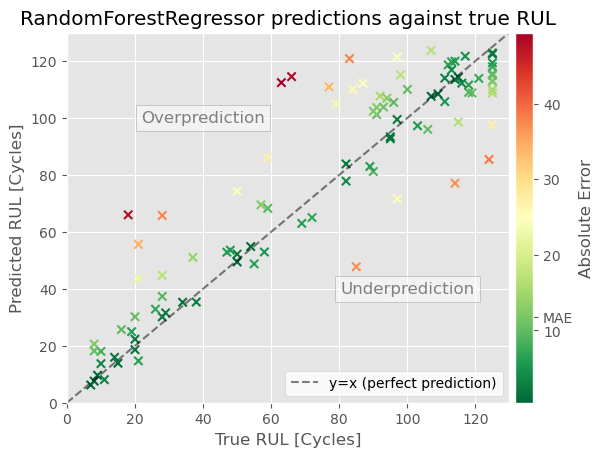

In [5]:
fig, ax = plt.subplots(figsize=fig_size(1, 0.5))

ax.scatter(test_labels, RFR_predictions, alpha=1, marker='x', c=np.abs(test_labels.to_numpy().flatten() - RFR_predictions), cmap='RdYlGn_r')
ax.plot([0, 130], [0, 130], color='black', alpha=0.5, linestyle='--', label='y=x (perfect prediction)')
ax.set_xlabel("True RUL [Cycles]")
ax.set_ylabel("Predicted RUL [Cycles]")
ax.set_title("RandomForestRegressor predictions against true RUL")

# add overprediction and underprediction regions
ax.text(40, 100, "Overprediction", fontsize=12, color='grey', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey'))
ax.text(100, 40, "Underprediction", fontsize=12, color='grey', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='grey'))
ax.set_ylim(0, 130)
ax.set_xlim(0, 130)

# colorbar
clb = plt.colorbar(ax.collections[0], label='Absolute Error', pad=0.01)
clb.ax.set_yticks([*clb.ax.get_yticks()[1:-1], MAE_test], labels=[*clb.ax.get_yticklabels()[1:-1], f'MAE'])


ax.legend(facecolor='white', loc='lower right')
plt.tight_layout()
plt.savefig("Output/randomforest_predictions_vs_true_RUL.png", bbox_inches='tight')
plt.show()

In [6]:
# Write predictions to file
with open("Output/randomforest_predictions.txt", "w") as f:
    for pred in RFR_predictions:
        f.write(f"{int(round(pred,0))}\n")